# Answering Business Questions using SQL
## Analysis of the Chinook database, a SQLite database file

Chinook is a music store similar to iTunes. The database consists of several tables including information regarding customers, tracks, purchases, and more. A database schema can be seen [here](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg).

### Importing Libraries, Defining Functions, and Overviewing the Database

First, the appropriate libraries and modules are imported, and several functions are defined. The show_tables function is executed to retrieve an overview of the database.

In [2]:
import sqlite3, pandas as pd, matplotlib.pyplot as plt, numpy as np
%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [4]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
def show_tables():
    return run_query('''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    ''')

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Selecting Albums to Purchase
Determining which genres sell best in the USA to inform the choice of which albums will be added to the store.

Return each genre with number of tracks sold in aboslute numbers and in percentages with a SQLite query.

In [7]:
run_query('''
WITH usa_track_table AS (
    SELECT
        il.*,
        t.name track,
        g.name genre,
        c.country
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    LEFT JOIN track t ON t.track_id = il.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    WHERE c.country == "USA"
)
SELECT
    genre,
    TOTAL(quantity) total_tracks,
    TOTAL(quantity) / (SELECT TOTAL(quantity) FROM usa_track_table) percentage_total
FROM usa_track_table
GROUP BY genre
ORDER BY 2 DESC
''')

,genre,total_tracks,percentage_total
0,Rock,561.0,0.533777
1,Alternative & Punk,130.0,0.123692
2,Metal,124.0,0.117983
3,R&B/Soul,53.0,0.050428
4,Blues,36.0,0.034253
5,Alternative,35.0,0.033302
6,Latin,22.0,0.020932
7,Pop,22.0,0.020932
8,Hip Hop/Rap,20.0,0.019029
9,Jazz,14.0,0.013321


The query returns a table featuring 17 genres and the absolute and percentage total of tracks purchased from each genre. The query will be assigned to a variable for further analysis and plotting.

In [8]:
usa_top_genres = run_query('''
WITH usa_track_table AS (
    SELECT
        il.*,
        t.name track,
        g.name genre,
        c.country
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    LEFT JOIN track t ON t.track_id = il.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    WHERE c.country == "USA"
)
SELECT
    genre,
    TOTAL(quantity) total_tracks,
    TOTAL(quantity) / (SELECT TOTAL(quantity) FROM usa_track_table) percentage_total
FROM usa_track_table
GROUP BY genre
ORDER BY 2 DESC
''')

First, using pandas and matplotlib, the data will be plotted as a barplot.

In [9]:
usa_top_genres.set_index("genre", drop=True, inplace=True) #axis labels automatically added to plot

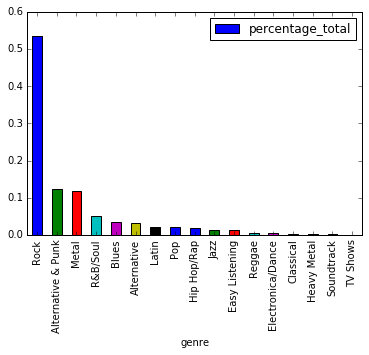

In [10]:
usa_top_genres.plot(kind='bar', y='percentage_total')
plt.show()

The barplot is very informative and probably the best option to display the data. However, to expand my skillset, I have opted to play around with seaborn and include a pie chart and an additional barplot.

In [11]:
tuple(len(usa_top_genres) * [0]) # tuple to create explode tuple for pie

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

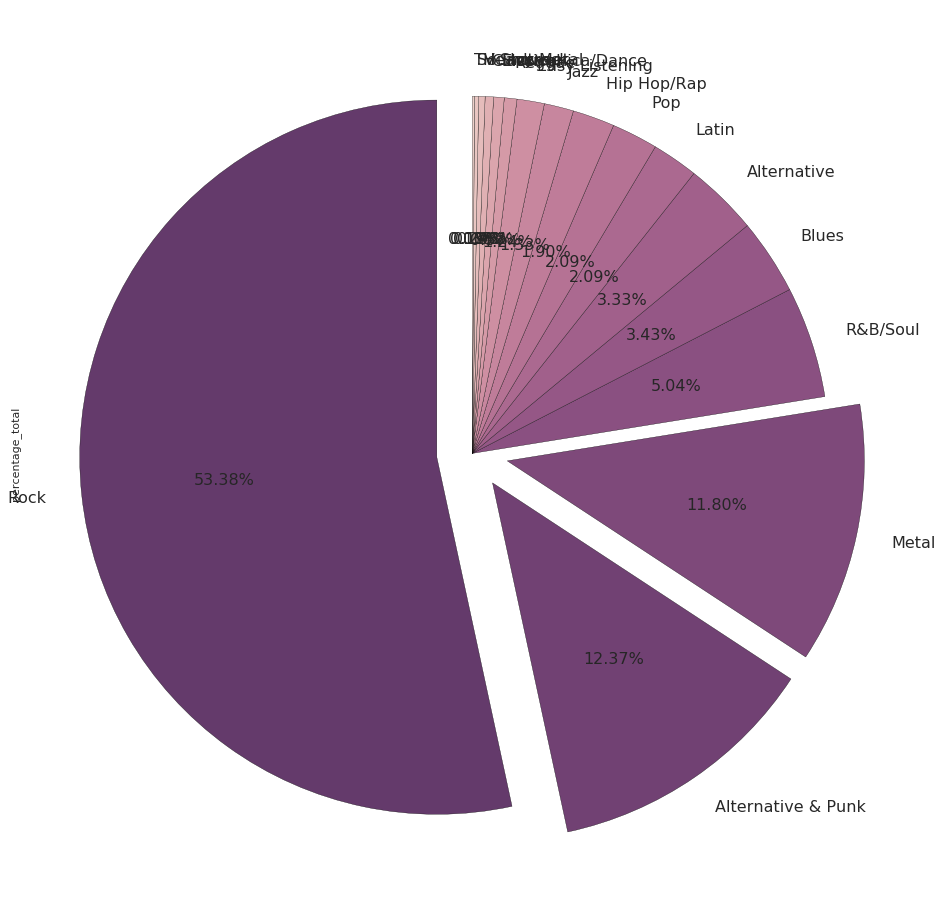

In [12]:
import seaborn as sns
colorchoice = sns.cubehelix_palette(17, reverse=True, dark=.3)
explodetuple = (0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
usa_top_genres.plot(figsize=(16,16), fontsize=16, kind='pie', y='percentage_total', startangle=90, legend=False, autopct='%.2f%%', colors=colorchoice, explode=explodetuple)
plt.show()

In [13]:
usa_top_genres.reset_index(inplace=True)

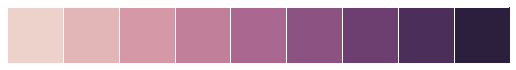

In [14]:
p=sns.choose_cubehelix_palette()

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


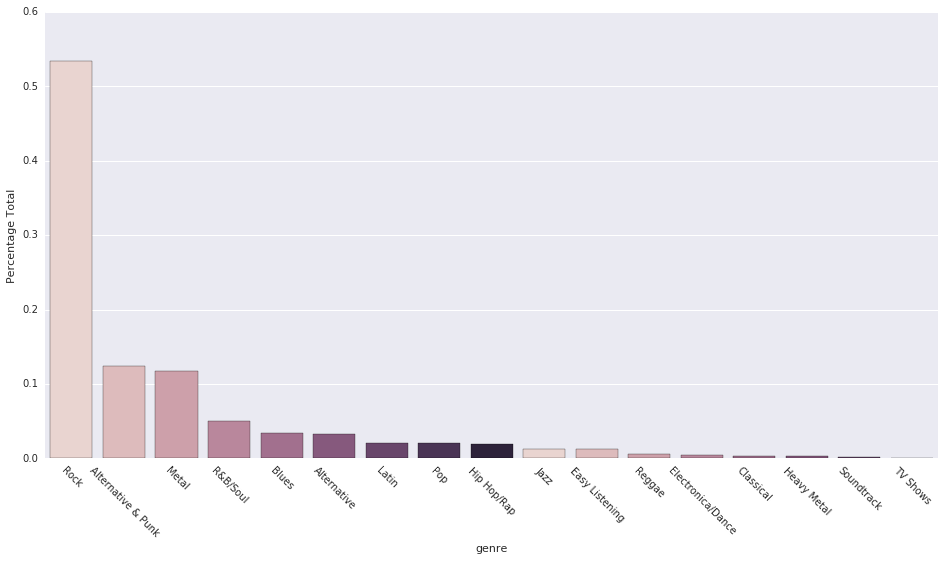

In [15]:
new_plot, ax1 = plt.subplots(1, 1, figsize=(16,8))
sns.barplot(x=usa_top_genres["genre"], y=usa_top_genres["percentage_total"], palette=p, ax=ax1)
plt.xticks(rotation=-45)
ax1.set_ylabel("Percentage Total")

To determine which albums should be purchased by Chinook from the record label, I will first create a new dataframe containing the artist and genre information from the record label and name it records. I will initiate an empty list named same_genres and append genres from usa_top_genres that correspond between usa_top_genres (the dataframe containing the genres purchased in the USA from Chinook) and records. Using this list, I will slice usa_top_genres to return a new dataframe (top_three) that only includes the top 3 corresponding genres and their respective total_tracks and percentage_totals. I will initiate an empty list (same_genre_top) and append genres from records that correspond between top_three and records. I will use this list to return a dataframe (my_picks) that includes my three record picks from the record label based on the best-selling genres in the USA.

* Separate lists were used to append genres and slice due to the difference in genre title in records and usa_top_genres (e.g. "Alternative/Punk" vs. "Punk").

In [16]:
record_label_records = [
    {"Artist Name": "Regal", "Genre": "Hip Hop"},
    {"Artist Name": "Red Tone", "Genre": "Punk"},
    {"Artist Name": "Meteor and the Girls", "Genre": "Pop"},
    {"Artist Name": "Slim Jim Bites", "Genre": "Blues"}
]
records = pd.DataFrame(record_label_records)
same_genres = []
for genre in usa_top_genres["genre"]:
    for i in records["Genre"]:
        if i in genre:
            same_genres.append(genre)
top_three = usa_top_genres[usa_top_genres["genre"].isin(same_genres)][:3]
same_genre_top = []
for genre in top_three["genre"]:
    for i in records["Genre"]:
        if i in genre:
            same_genre_top.append(i)
my_picks = records[records["Genre"].isin(same_genre_top)]
my_picks

,Artist Name,Genre
1,Red Tone,Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


NOTE: I would like to figure out how to order the above dataframe by the order of genres in usa_top_genres. I also would like to figure out how to append top_three to my_picks.

#### Which Albums to Purchase
The top 3 best selling genres in the USA that correspond with the genres provided by the record label are Punk, Pop, and Blues. Based on these trends, it is recommended that Chinook select the albums by Red Tone, Meteor and the Girls, and Slim Jim Bites.

#### Playing around with pandas some more
I'm going to "clean" the record label dataframe by making the record label genres equivalent to the corresponding usa_top_genres. I will then slice usa_top_genres down to those genres only present in the record label dataframe and join the record label dataframe to this slice. I will then narrow it to the top 3 to give me my picks for Chinook.

In [17]:
for genre in usa_top_genres["genre"]: # for loop to identify corresponding genres and replace record genres with usa_top_genres
    for i in records["Genre"]:
        if i in genre:
            records["Genre"] = records["Genre"].replace(i, genre)
records

,Artist Name,Genre
0,Regal,Hip Hop/Rap
1,Red Tone,Alternative & Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


In [18]:
top_genres = usa_top_genres[usa_top_genres["genre"].isin(records["Genre"])] # narrow usa_top_genres to only those genres offered by record label
top_genres

,genre,total_tracks,percentage_total
1,Alternative & Punk,130.0,0.123692
4,Blues,36.0,0.034253
7,Pop,22.0,0.020932
8,Hip Hop/Rap,20.0,0.019029


I'm going to set the records index to the genre column. Then I will join the top_genres dataframe to the records dataframe based on the genre columns.

In [19]:
# first, using merge
top_genres.merge(records, how="inner", left_on="genre", right_on="Genre", copy=False)

,genre,total_tracks,percentage_total,Artist Name,Genre
0,Alternative & Punk,130.0,0.123692,Red Tone,Alternative & Punk
1,Blues,36.0,0.034253,Slim Jim Bites,Blues
2,Pop,22.0,0.020932,Meteor and the Girls,Pop
3,Hip Hop/Rap,20.0,0.019029,Regal,Hip Hop/Rap


In [20]:
# now, using join to eliminate extra column
top_genres.join(records.set_index("Genre"), on="genre")

,genre,total_tracks,percentage_total,Artist Name
1,Alternative & Punk,130.0,0.123692,Red Tone
4,Blues,36.0,0.034253,Slim Jim Bites
7,Pop,22.0,0.020932,Meteor and the Girls
8,Hip Hop/Rap,20.0,0.019029,Regal


In [21]:
# using join, creating a dataframe that only includes my top 3 picks
my_top_three = top_genres.join(records.set_index("Genre"), on="genre")[:3]
my_top_three

,genre,total_tracks,percentage_total,Artist Name
1,Alternative & Punk,130.0,0.123692,Red Tone
4,Blues,36.0,0.034253,Slim Jim Bites
7,Pop,22.0,0.020932,Meteor and the Girls


### Analyzing Employee Sales Performance

In [22]:
run_query('''
WITH sales_support AS (
    SELECT
        e1.employee_id,
        e1.first_name || " " || e1.last_name employee_name,
        e2.first_name || " " || e2.last_name supervisor_name,
        e2.title supervisor_title,
        e1.birthdate,
        e1.hire_date,
        e1.city,
        e1.state,
        e1.country,
        e1.postal_code,
        e1.phone,
        e1.email
    FROM employee e1
    INNER JOIN employee e2 ON e2.employee_id = e1.reports_to
    WHERE e1.title == "Sales Support Agent"
)
SELECT
    s.*,
    TOTAL(i.total) total_sales
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN sales_support s ON s.employee_id = c.support_rep_id
GROUP BY s.employee_id
''')

,employee_id,employee_name,supervisor_name,supervisor_title,birthdate,hire_date,city,state,country,postal_code,phone,email,total_sales
0,3,Jane Peacock,Nancy Edwards,Sales Manager,1973-08-29 00:00:00,2017-04-01 00:00:00,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,jane@chinookcorp.com,1731.51
1,4,Margaret Park,Nancy Edwards,Sales Manager,1947-09-19 00:00:00,2017-05-03 00:00:00,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,margaret@chinookcorp.com,1584.00
2,5,Steve Johnson,Nancy Edwards,Sales Manager,1965-03-03 00:00:00,2017-10-17 00:00:00,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,steve@chinookcorp.com,1393.92


It appears that those Sales Support Agents that were hired earlier in the year reported greater total sales. Additionally, the two agents with the higher sales have the same area code in their phone numbers and the same first four characters in their postal code.

In [23]:
sales_support_sales = run_query('''
WITH sales_support AS (
    SELECT
        e1.employee_id,
        e1.first_name || " " || e1.last_name employee_name,
        e2.first_name || " " || e2.last_name supervisor_name,
        e2.title supervisor_title,
        e1.birthdate,
        e1.hire_date,
        e1.city,
        e1.state,
        e1.country,
        e1.postal_code,
        e1.phone,
        e1.email
    FROM employee e1
    INNER JOIN employee e2 ON e2.employee_id = e1.reports_to
    WHERE e1.title == "Sales Support Agent"
)
SELECT
    s.*,
    TOTAL(i.total) total_sales
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN sales_support s ON s.employee_id = c.support_rep_id
GROUP BY s.employee_id
''') #assigning SQLite query to variable for plotting

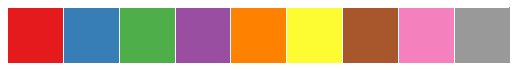

In [24]:
cp = sns.choose_colorbrewer_palette(data_type="q")

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


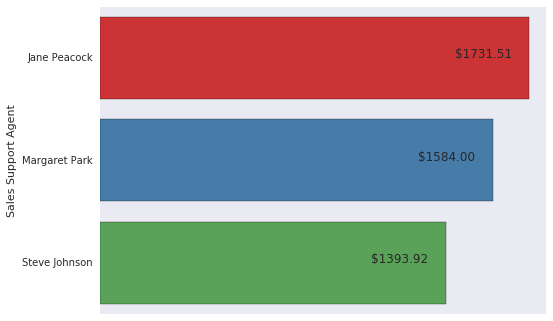

In [25]:
sales_plot, ax = plt.subplots()
sns.barplot(x=sales_support_sales["total_sales"], y=sales_support_sales["employee_name"], palette=cp, ax=ax)
ax.set_xlabel("Total Sales in USD")
ax.set_ylabel("Sales Support Agent")
ax.xaxis.set_visible(False)
for i, v in enumerate(sales_support_sales["total_sales"]):
    ax.text(v-300, i, "${0:.2f}".format(v))

plt.show()

### Analyzing Sales by Country

In [26]:
run_query('''
WITH country_data AS (
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*) FROM customer WHERE country = c.country
            ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        COUNT(DISTINCT c.customer_id) total_customers,
        TOTAL(i.total) total_sales,
        COUNT(DISTINCT i.invoice_id) total_orders
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
)
SELECT
    country,
    total_customers,
    total_sales,
    total_sales / total_customers avg_sale_per_customer,
    total_sales / total_orders average_order_value
FROM (
    SELECT
        cd.*,
        CASE
            WHEN cd.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_data cd
)
ORDER BY sort, total_sales DESC
''')

,country,total_customers,total_sales,avg_sale_per_customer,average_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


In [28]:
country_data = run_query('''
WITH country_data AS (
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*) FROM customer WHERE country = c.country
            ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        COUNT(DISTINCT c.customer_id) total_customers,
        TOTAL(i.total) total_sales,
        COUNT(DISTINCT i.invoice_id) total_orders
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
)
SELECT
    country,
    total_customers,
    total_sales,
    total_sales / total_customers avg_sale_per_customer,
    total_sales / total_orders average_order_value
FROM (
    SELECT
        cd.*,
        CASE
            WHEN cd.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_data cd
)
ORDER BY sort, total_sales DESC
''')
country_data

,country,total_customers,total_sales,avg_sale_per_customer,average_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


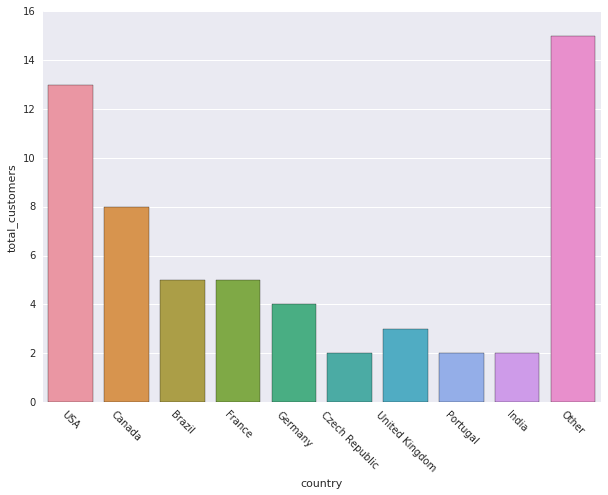

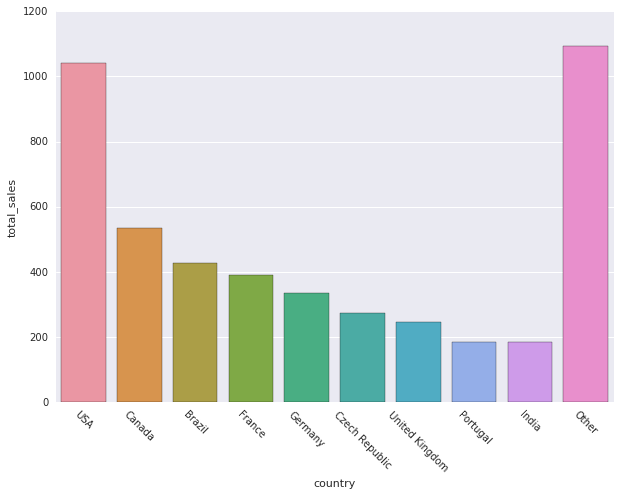

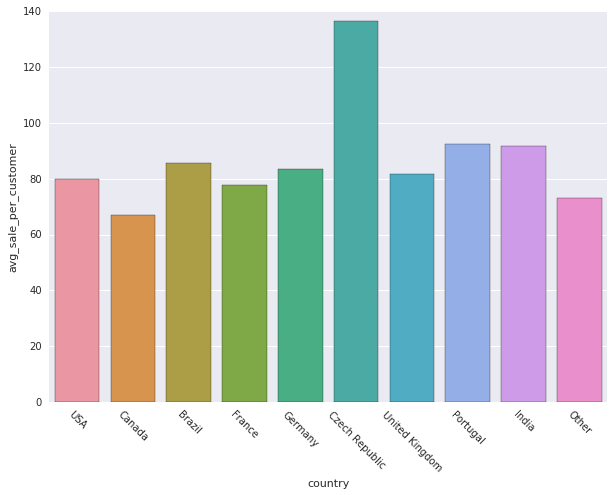

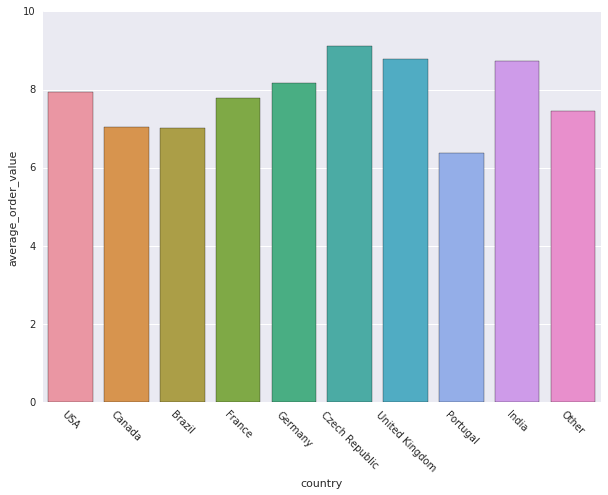

In [37]:
dimensions = ["total_customers", "total_sales", "avg_sale_per_customer", "average_order_value"]
for dimension in dimensions:
    fig, ax = plt.subplots(figsize=(10,7))
    sns.barplot(x=country_data['country'], y=country_data[dimension], ax=ax)
    plt.xticks(rotation=-45)
    ax.set_ylabel(dimension)
    plt.show()

* Other has the most customers. USA has the second most customers.
* Other has the most total sales. USA has the second most total sales.
* Czech Republic has the highest average sale per customer.
* Czech Republic has the highest average order value.

There are only two customers from the Czech Republic, but those customers have the highest average sale per customer. Czech Republic could be an area for growth as increasing customers could increase sales if other Czech customers spend as much as our existing customers.
The countries that have only 1 customer are still contributing significantly to sales. Marketing should be increased in these countries to increase customers and further increase sales.